# Quantum Software Consortium Training Days

## Day 1: Machine learning for quantum physics

This notebook contains several different examples of machine learning applications in (quantum) physics.

#### External resources

Stochastic Gradient Descent:
https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/8.SGD-minibatch-mnist.ipynb

In [1]:
## Uncomment this to get data when you run on google colab:
#!git clone https://github.com/everthemore/QSC-2024.git

In [235]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
from functools import partial

import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from numpy import random

fig_size_dim    = 8
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 8
    dpi             =  500

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
                }

    plt.rcParams.update(params)
plot_style()

## Ising Model Data

#### Background
The Ising model is a mathematical model used in statistical mechanics to describe ferromagnetism. It consists of discrete variables called spins, which can be in one of two states ($+1$ or $-1$). These spins are arranged on a lattice, and each spin interacts with its nearest neighbors.

A phase transition is a change in the macroscopic properties of a system when a control parameter, such as temperature, is varied. In the Ising model, a phase transition occurs at a critical temperature 
$𝑇_c$, below which the spins are aligned (ferromagnetic phase) and above which the spins are randomly oriented (paramagnetic phase).

The energy of the system is determined by the Hamiltonian:

$ H = -J \sum_{\langle i,j \rangle} s_i s_j - h \sum_i s_i $

where:
- $ J $ is the interaction strength between neighboring spins,
- $ \langle i,j \rangle $ denotes the sum over neighboring pairs of spins,
- $ s_i $ is the spin at site $ i $,
- $ h $ is the external magnetic field.

To simulate the Ising model, we use the Wolff Monte Carlo algorithm, which efficiently samples spin configurations at a given temperature $T$. This algorithm will enable us understand the behavior of the system near the critical temperature and study the phase transitions in the model.

In [236]:
class WolffMonteCarlo:
    """
    Wolff Monte Carlo simulator for the 2D Ising model.

    Attributes:
    L (int): The linear size of the grid.
    T (float): The temperature of the system.
    _K (float): A constant derived from the temperature.
    _state (np.ndarray): The current state of the spin configuration.
    _updater (function): A partial function for the Wolff iterative update.
    """

    def __init__(self, L, T):
        """
        Initializes the WolffMonteCarlo instance.

        Parameters:
        L (int): The linear size of the grid.
        T (float): The temperature of the system.
        """
        self._L = L
        self._T = T
        self._K = 2. / T
        self._state = np.random.choice([-1, 1], size=[L, L])
        self._updater = partial(self.wolff_iterative)

    @property
    def state(self):
        """
        Returns the current state of the spin configuration.
        
        Returns:
        np.ndarray: The current spin configuration.
        """
        return self._state

    def probability_add_bond(self, x1, y1, x2, y2, state):
        """
        Computes the probability of adding a bond between two spins.

        Parameters:
        x1, y1 (int): Coordinates of the first spin.
        x2, y2 (int): Coordinates of the second spin.
        state (np.ndarray): The current state of the spin configuration.

        Returns:
        float: The probability of adding a bond between the two spins.
        """
        return 1. - np.exp(-self._K * (1. if state[x1, y1] == state[x2, y2] else 0.))

    def wolff_iterative(self, state):
        """
        Performs one iteration of the Wolff cluster update.

        Parameters:
        state (np.ndarray): The current state of the spin configuration.

        Returns:
        set: A set of coordinates to flip.
        """
        L = self._L
        left = [L - 1] + list(range(L - 1))
        right = list(range(1, L)) + [0]
        sites_to_consider = deque()
        sites_to_flip = set()
        bonds_considered = set()
        sites_to_consider.append((np.random.randint(0, L), np.random.randint(0, L)))

        while sites_to_consider:
            x1, y1 = sites_to_consider.pop()
            for x2, y2 in zip([left[x1], right[x1], x1, x1], [y1, y1, left[y1], right[y1]]):
                if not (x1, y1, x2, y2) in bonds_considered:
                    bonds_considered.add((x1, y1, x2, y2))
                    bonds_considered.add((x2, y2, x1, y1))
                    if np.random.rand() < self.probability_add_bond(x1, y1, x2, y2, state):
                        sites_to_consider.append((x2, y2))
                        sites_to_flip.add((x1, y1))
                        sites_to_flip.add((x2, y2))
        return sites_to_flip

    def step(self):
        """
        Performs one update step of the Wolff Monte Carlo simulation.

        Returns:
        set: A set of coordinates that were flipped.
        """
        to_flip = self._updater(self._state)
        for (x, y) in to_flip:
            self._state[x, y] *= -1
        return to_flip


def generate_Ising_configurations(L, numSamplesPerT, T, equilibrationSteps=100):
    """
    Generates configurations for the 2D Ising model using Wolff cluster updates.

    Parameters:
    L (int): The linear size of the grid.
    numSamplesPerT (int): The number of samples to generate per temperature.
    T (float): The temperature of the system.
    equilibrationSteps (int, optional): Number of steps to equilibrate the system. Defaults to 100.

    Returns:
    np.ndarray: A list of generated spin configurations.
    """
    sim = WolffMonteCarlo(L=L, T=T)
    res = []
    for s in range(numSamplesPerT + equilibrationSteps):
        c = 0
        while c < 1:
            to_flip = sim.step()
            c += len(to_flip) / (L * L)
        if s >= equilibrationSteps:
            res.append(sim.state.copy())
    return np.array(res)


def generate_data(L, temperatures, numSamplesPerT, equilibrationSteps=1000):
    """
    Generates spin configurations and magnetization data for a range of temperatures.

    Parameters:
    L (int): The linear size of the grid.
    temperatures (list): A list of temperatures to simulate.
    numSamplesPerT (int): Number of samples to generate per temperature.
    equilibrationSteps (int, optional): Number of equilibration steps. Defaults to 1000.

    Returns:
    np.ndarray: A list of spin configurations.
    np.ndarray: A list of magnetization values.
    """
    data = []
    magnetizations = []

    for T in tqdm(temperatures):
        spins = generate_Ising_configurations(L, numSamplesPerT, T, equilibrationSteps)
        magnetization = [np.sum(config) / (L * L) for config in spins]
        data.extend(spins)
        magnetizations.extend(magnetization)

    return np.array(data), np.array(magnetizations)


def plot_lattice(configurations, magnetizations):
    """
    Plot the lattice configuration.

    Parameters:
    configurations (np.ndarray): Array of spin configurations.
    magnetizations (np.ndarray): Array of magnetization values.
    """
    fig, axs = plt.subplots(1, 3)

    axs[0].imshow(configurations[0], cmap='gray', interpolation='nearest')
    axs[1].imshow(configurations[len(configurations) // 2], cmap='gray', interpolation='nearest')
    im = axs[2].imshow(configurations[-1], cmap='gray', interpolation='nearest')

    axs[0].set_xlabel(f"Magnetization: {np.round(magnetizations[0], 3)}")
    axs[1].set_xlabel(f"Magnetization: {np.round(magnetizations[len(magnetizations) // 2], 3)}")
    axs[2].set_xlabel(f"Magnetization: {np.round(magnetizations[-1], 3)}")

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Spin')
    axs[1].set_title('2D Ising Model Configuration')
    plt.show()


## Zipping the Ising Model

In [279]:
# The temperatures that we are going to generate samples at
Ts = np.arange(1.6, 3.0, 0.1) #np.arange(1.95, 0.04, -0.1) * 2.27

# For a few different system sizes, store the data in a dictionary with L as key
all_data = {}
for L in [10, 20, 40]:#, 80]:
    all_data[L], _ = generate_data(L, Ts, 1000) # Returns half the number of samples asked for

100%|████████████████████████████████████████████████████████████████████████████████████| 14/14 [03:01<00:00, 12.95s/it]


In [238]:
import gzip
import shutil

sizes = {}
Ts = np.arange(1.6, 3.0, 0.1)
for L in [10, 20, 40]:#, 80]:
    sizes[L] = []

    for t,T in enumerate(Ts):
        data = all_data[L][1000*t : 1000*(t+1)]
        out = gzip.compress(data)
        sizes[L].append(out.__sizeof__())

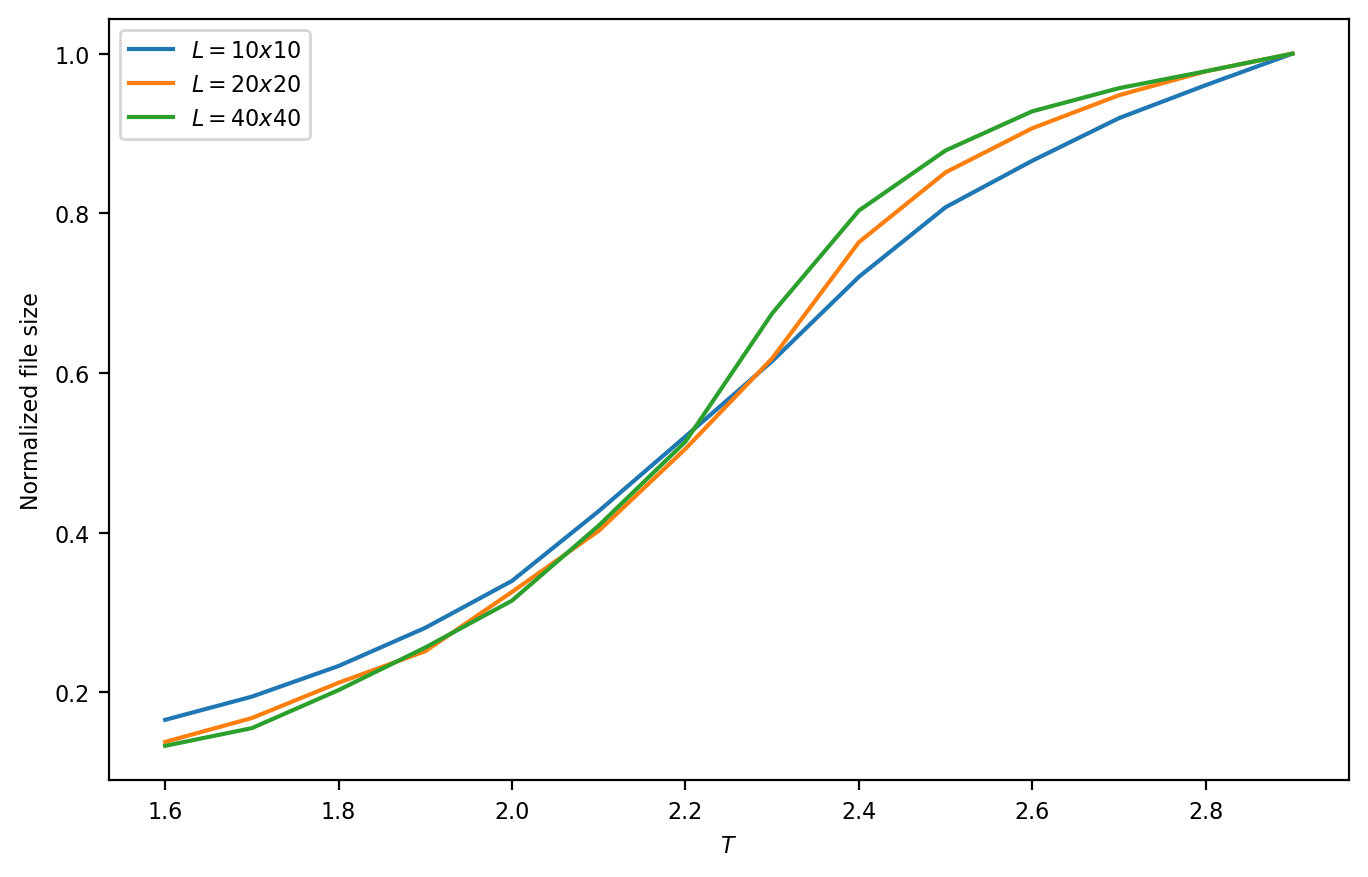

In [239]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=200)
for L in [10, 20, 40]:#, 80]:
    ax.plot(Ts, sizes[L]/np.max(sizes[L]), label='$L=%dx%d$'%(L,L))
    
ax.set_xlabel("$T$")
ax.set_ylabel("Normalized file size")
ax.legend(fancybox=True)

## PCA'ing the Ising Model

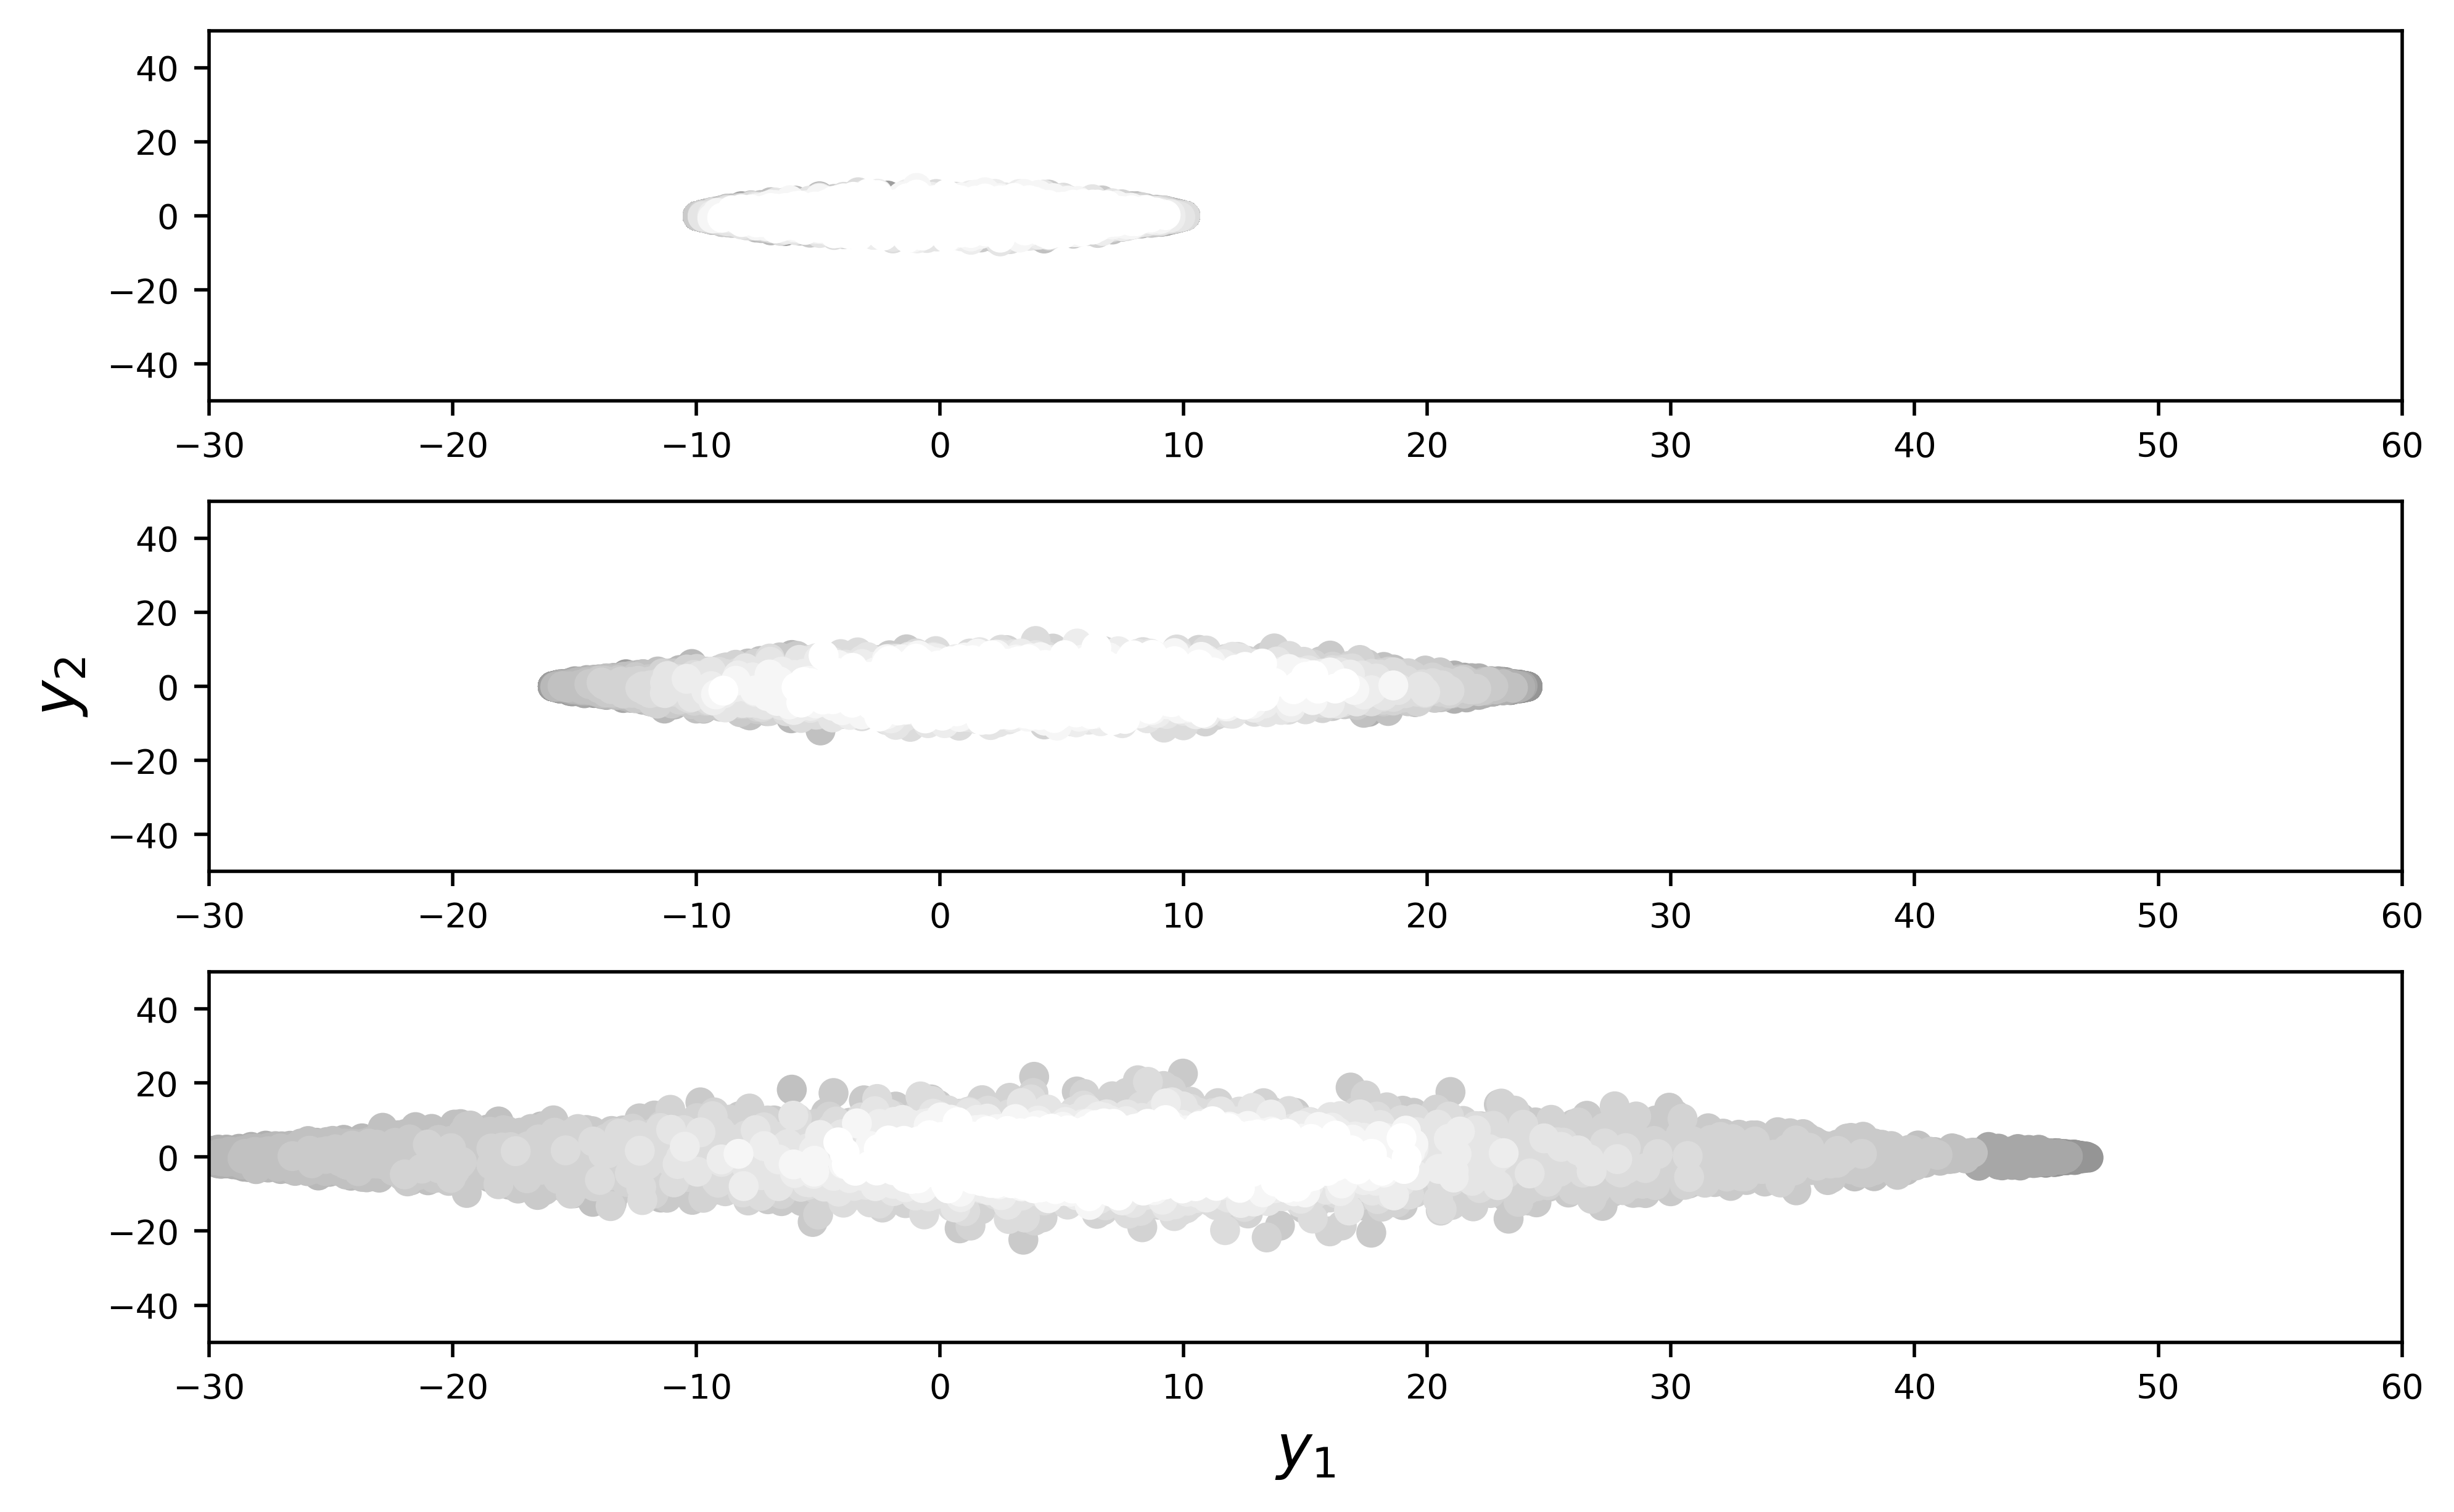

In [280]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots(3,1)
Ts = np.arange(1.6, 3.0, 0.1)
principal_vectors = [] 
for a,L in enumerate([10,20,40]):
    raw_x = []
    colors = [] 
   
    for t,T in enumerate(Ts):
        data = all_data[L][1000*t:1000*(t+1)].reshape(1000,L**2)
        for c,snapshot in enumerate(data):
            raw_x.append( snapshot )
            colors.append( np.array([1, 1, 1]) * T/np.max(Ts) ) 

    pca = PCA(n_components=2)
    pca.fit(raw_x)
    proj = pca.transform(raw_x)
    principal_vectors.append( pca.components_[0] )
    ax[a].scatter(proj[:,0], proj[:,1], color=colors)
    
    ax[a].set_xlim([-30,60])
    ax[a].set_ylim([-50,50])
    
ax[1].set_ylabel("$y_2$", fontsize=14)
ax[2].set_xlabel("$y_1$", fontsize=14)
fig.tight_layout()

Text(0, 0.5, 'First principal component vector')

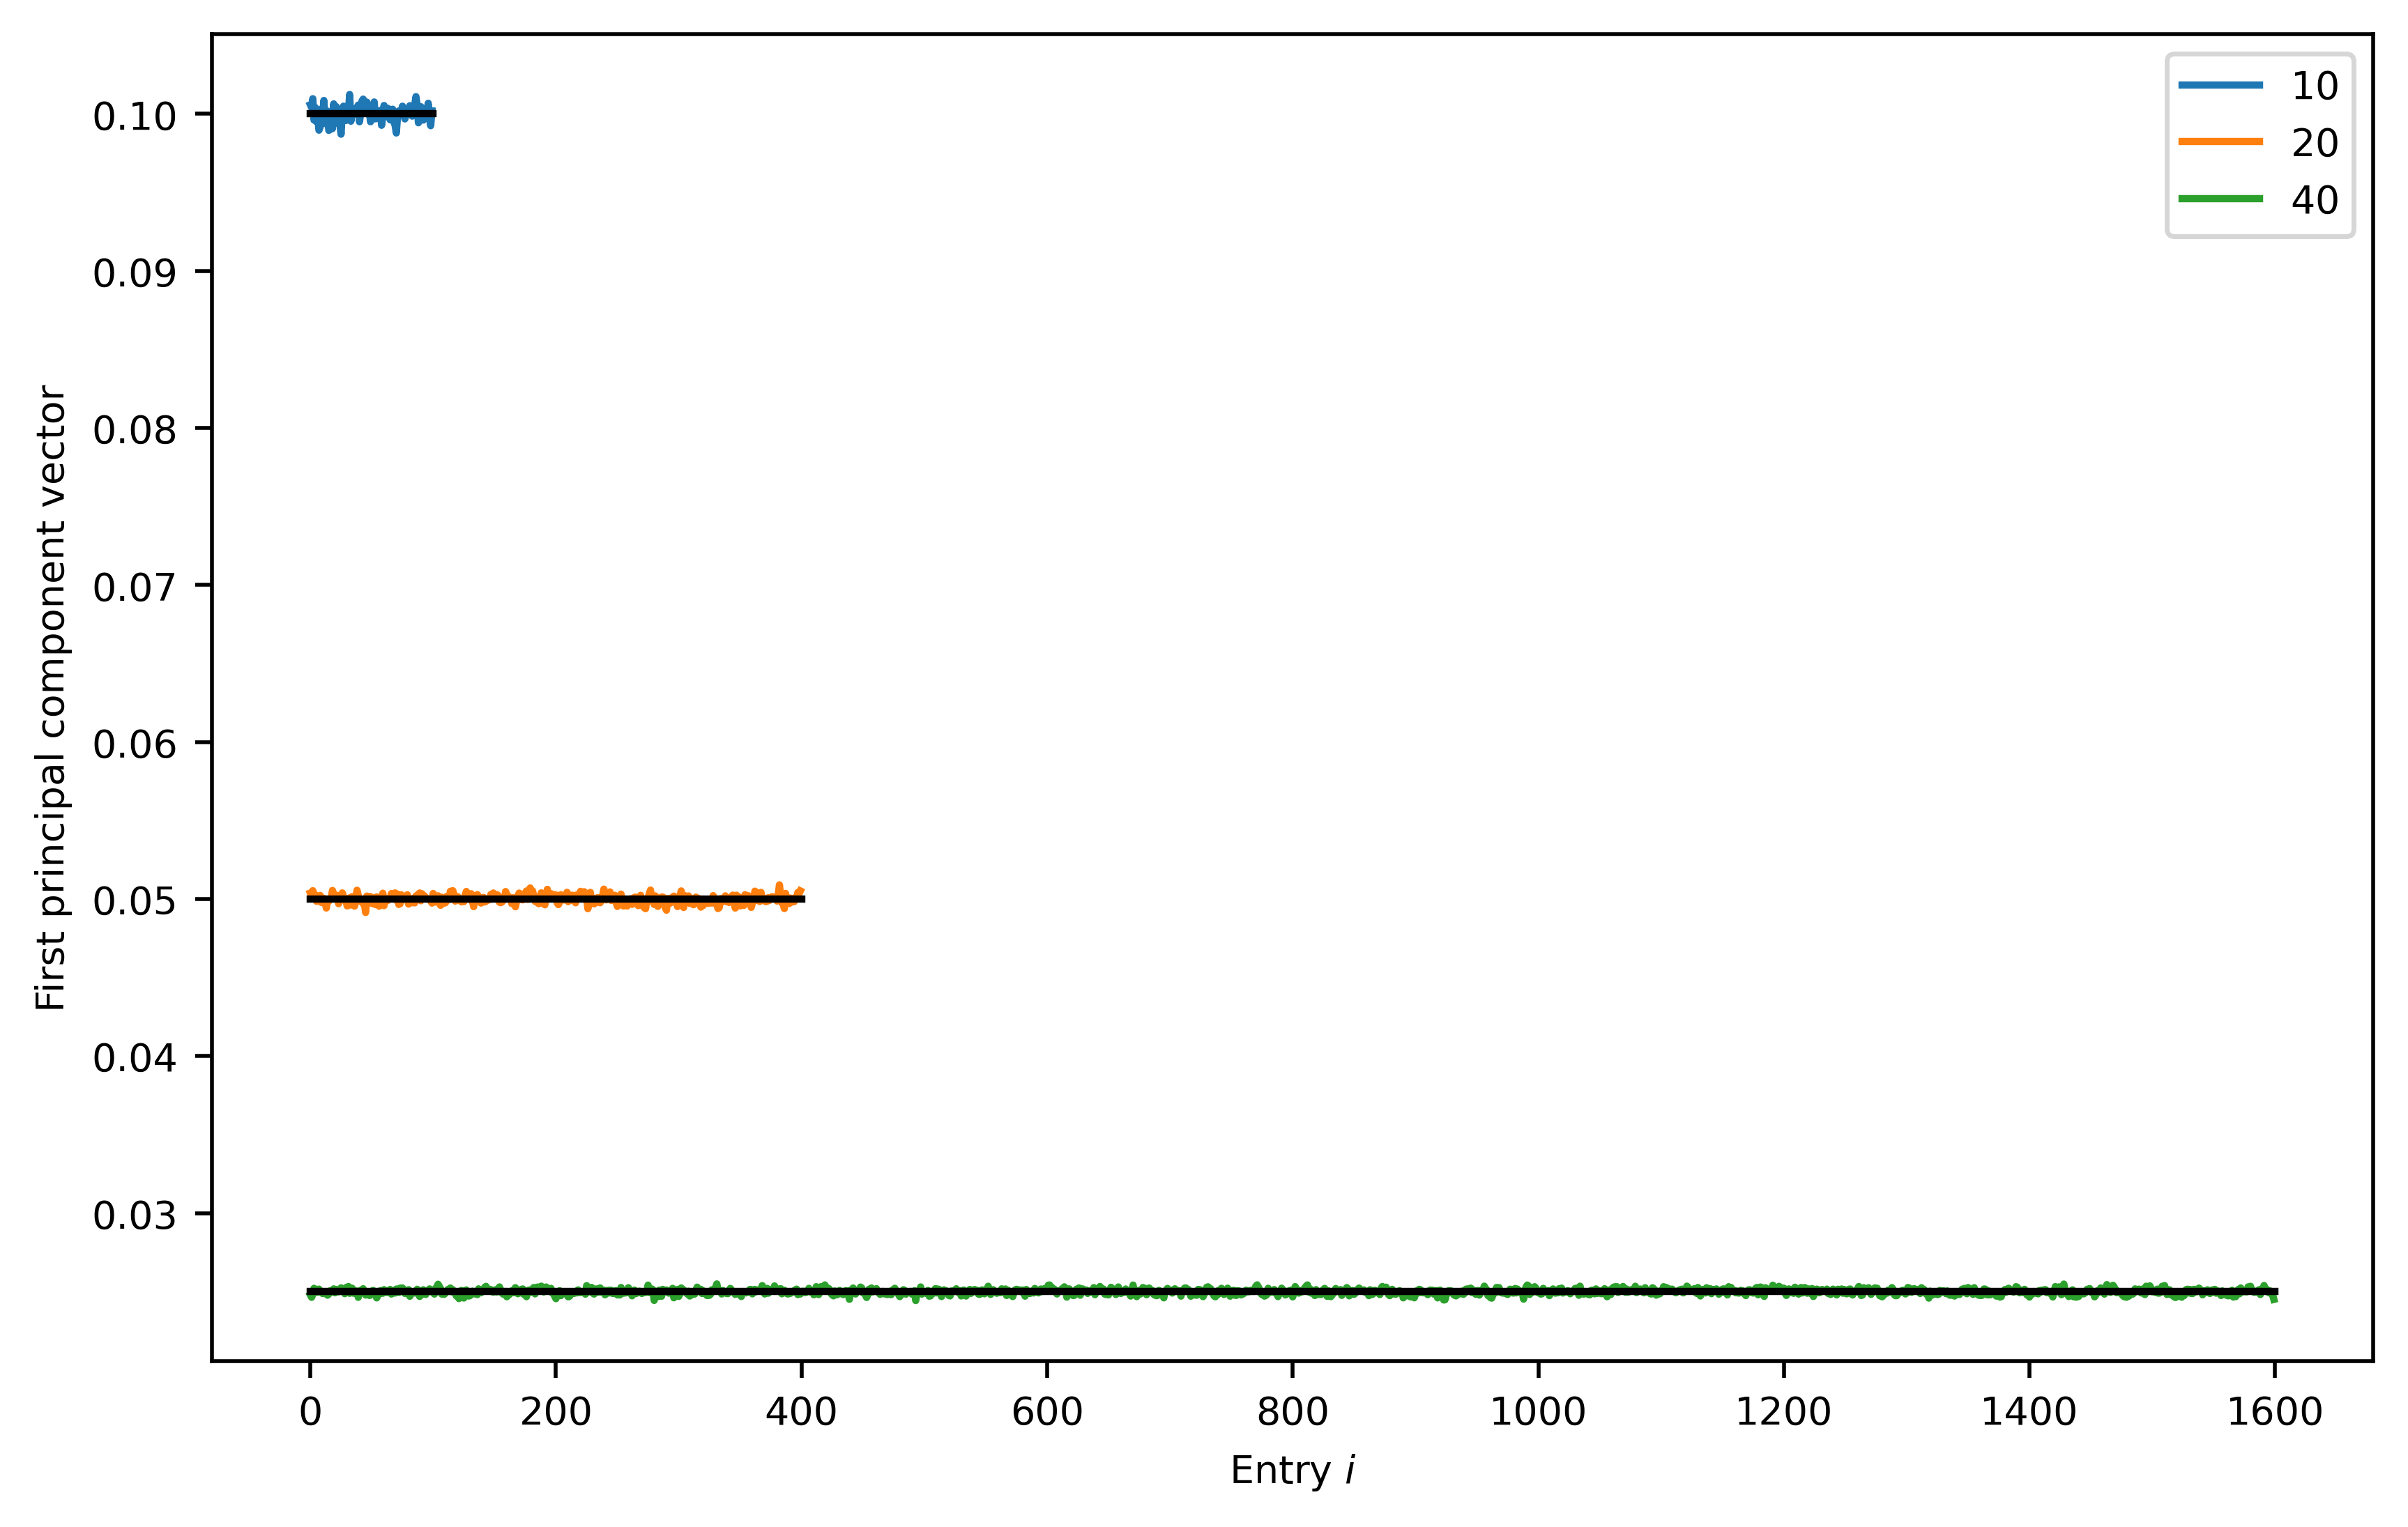

In [241]:
fig, ax = plt.subplots()

for a,L in enumerate([10,20,40]):
    ax.plot(np.abs(principal_vectors[a]), label="$%d$"%L)
    ax.plot([0, L**2], [1/L, 1/L], c='k')
    
ax.legend(fancybox=True)
ax.set_xlabel("Entry $i$")
ax.set_ylabel("First principal component vector")

We see here that the dominant principal component is quite a uniform vector. Think about what this means for when we project a sample 
 to the latent space. If the principal component vector 
 is uniform with value, then 
 is just the (sum of x)/L. And the sum of x is the total magnetization, which we know can act as an order parameter!

### Other ideas to try yourself next

Try out k-means, t-SNE

## Supervised learning 

In [242]:
import torch
import torch.nn as nn            
import torch.nn.functional as F 
import torch.optim as optim

In [243]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#### Make a dataset with __labelled__ examples

In [244]:
L = 20
all_temperatures = np.linspace(1.4, 3.5, 30)
train_temperatures = np.concatenate([all_temperatures[:8], all_temperatures[-8:]])
numSamplesPerT = 200
equilibrationSteps = 1000

configurations, _ = generate_data(L, all_temperatures, numSamplesPerT, equilibrationSteps)
print(f"Generated {len(configurations)} data points.")

X = configurations
y = []

# Notice that we put in an estimate for the critical temperature here already! It is not too 
# important, as long as we make sure that we only choose to train on temperatures far away from it
for T in train_temperatures:
    if T < 2:
        y += numSamplesPerT*[[1,0]]
    else:
        y += numSamplesPerT*[[0,1]]
        
# Now we only select those datapoints we want to train on, and then split them into a train and test set
X_to_train = np.concatenate([X[:8*numSamplesPerT], X[-8*numSamplesPerT:]])
y_to_train = np.concatenate([y[:8*numSamplesPerT], y[-8*numSamplesPerT:]])
   
X_to_train = torch.from_numpy(np.array(X_to_train)).type(torch.float)
y_to_train = torch.from_numpy(np.array(y_to_train)).type(torch.float)

# Also make one with all configurations
X_all = torch.from_numpy(np.array(X)).type(torch.float)

100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:55<00:00,  1.85s/it]

Generated 6000 data points.


In [245]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_to_train, 
                                                    y_to_train, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(2560, 640, 2560, 640)

In [246]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(L**2,32),
            nn.ReLU(),
            nn.Linear(32,2),
        )

    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# here we initialize an instance of the class
model = NeuralNetwork().to(device)
# print the status of the model
# the print command is inherited from nn.Module in the definition of the network
print(model)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {pytorch_total_params}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=400, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)
Trainable parameters: 12898


In [247]:
# Make predictions with the model
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 640, Shape: torch.Size([640, 2])
Length of test samples: 640, Shape: torch.Size([640, 2])

First 10 predictions:
tensor([[-0.3524,  0.0477],
        [-0.2740, -0.0059],
        [-0.1263,  0.4613],
        [ 0.2052,  0.1309],
        [-0.4732,  0.0803],
        [-0.1358, -0.1939],
        [-0.0202, -0.0749],
        [-0.7086, -0.0617],
        [ 0.0797,  0.1427],
        [-0.5136,  0.0759]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])


In [248]:
loss_fn = nn.CrossEntropyLoss() # we use Cross Entropy as loss
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2) # The optimizer is Adam

In [249]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [250]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 200

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
  
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=np.argmax(y_train,axis=1), y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.68402, Accuracy: 53.32% | Test loss: 1.20507, Test acc: 103.28%
Epoch: 10 | Loss: 0.38045, Accuracy: 87.07% | Test loss: 0.34667, Test acc: 115.62%
Epoch: 20 | Loss: 0.23944, Accuracy: 94.22% | Test loss: 0.24652, Test acc: 173.44%
Epoch: 30 | Loss: 0.10615, Accuracy: 98.67% | Test loss: 0.12894, Test acc: 186.88%
Epoch: 40 | Loss: 0.03583, Accuracy: 99.80% | Test loss: 0.06311, Test acc: 194.69%
Epoch: 50 | Loss: 0.01393, Accuracy: 99.96% | Test loss: 0.03172, Test acc: 197.34%
Epoch: 60 | Loss: 0.00693, Accuracy: 100.00% | Test loss: 0.02042, Test acc: 197.97%
Epoch: 70 | Loss: 0.00422, Accuracy: 100.00% | Test loss: 0.01488, Test acc: 198.28%
Epoch: 80 | Loss: 0.00304, Accuracy: 100.00% | Test loss: 0.01227, Test acc: 198.75%
Epoch: 90 | Loss: 0.00239, Accuracy: 100.00% | Test loss: 0.01107, Test acc: 198.75%
Epoch: 100 | Loss: 0.00197, Accuracy: 100.00% | Test loss: 0.01026, Test acc: 198.75%
Epoch: 110 | Loss: 0.00167, Accuracy: 100.00% | Test loss: 0.00956, Tes

In [251]:
# TODO for you: modify so that you can make a plot of the accuracy and loss (both train/test) vs epochs

#### Now use trained model to also predict on unseen temperatures

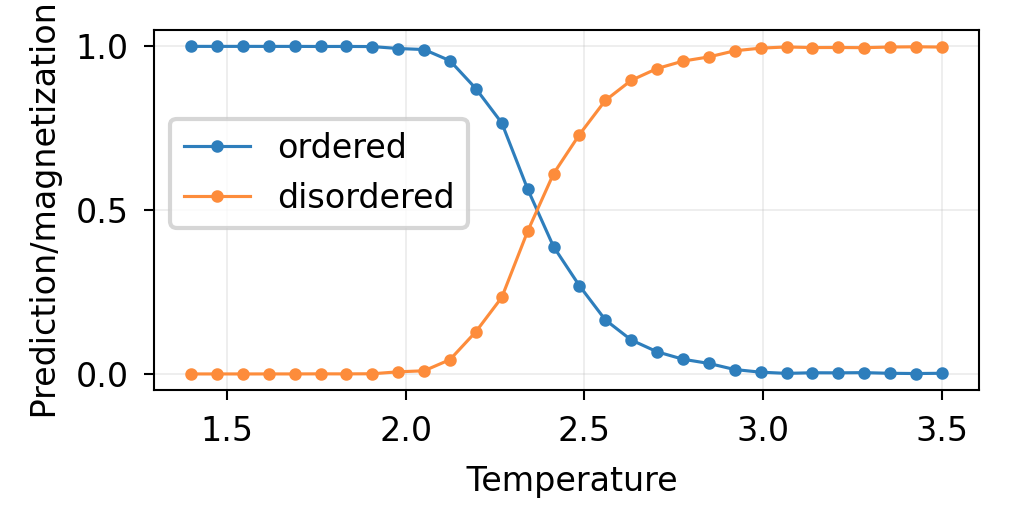

In [252]:
# Predict on all samples
test_logits = model(X_all).squeeze() 
test_pred = torch.softmax(test_logits, dim=1)

phase1 = test_pred[:,0].detach().numpy()
phase2 = test_pred[:,1].detach().numpy()

phase1 = np.array([np.mean(phase1[numSamplesPerT*i:numSamplesPerT*(i+1)]) for i in range(len(all_temperatures))])
phase2 = np.array([np.mean(phase2[numSamplesPerT*i:numSamplesPerT*(i+1)]) for i in range(len(all_temperatures))])
#m = np.array([np.abs(np.mean(magnetizations[numSamplesPerT*i:numSamplesPerT*(i+1)])) for i in range(len(evaluate_temperatures))])




fig, axes = plt.subplots(ncols=1, nrows=1, dpi=300)
ax = axes

fig.set_size_inches(3.40457, 1.8)
font = {'size' : 8}
mpl.rc('font', **font)
fig.subplots_adjust(bottom = 0.2, top=0.98, left=0.12, right=0.99)

for axx in [ax]:
        for axis in ['top','bottom','left','right']:
            axx.spines[axis].set_linewidth(0.5)
        axx.tick_params(width=0.5, which='both')
        axx.tick_params(length=2.5, which='major')
        axx.tick_params(length=1.5, which='minor')

ax.plot(all_temperatures, phase1, '-o',  label='ordered', markersize=2,linewidth=0.75,color = plt.cm.Blues(0.7))
ax.plot(all_temperatures, phase2, '-o',  label='disordered', markersize=2,linewidth=0.75,color = plt.cm.Oranges(0.5))
#ax.plot(evaluate_temperatures, m, '--',  label="magnetization", markersize=2,linewidth=0.75,color = plt.cm.Greens(0.5))

ax.tick_params(labelsize = 8)
ax.set_xlabel(r" Temperature", fontsize = 8)
ax.set_ylabel(r" Prediction/magnetization ", fontsize = 8, labelpad=3)
ax.set_yticklabels([],minor=True)
ax.grid(True, which='both',linewidth=0.1)
ax.set_yticks([0, 0.5, 1.0],minor=False)
ax.legend( bbox_to_anchor=(0.0, 0.80), loc='upper left')
# ax.set_ylim(-0.25, 1.25)
plt.savefig("ising_phase_transition.pdf")
plt.tight_layout()
plt.show()

In [254]:
index = (np.abs(phase1 - 0.5)).argmin()
tc = all_temperatures[index]
print("Estimated Transition Temperature =", tc)

Estimated Transition Temperature = 2.3413793103448275


------

## Exercise: implement "Learning by Confusion" 

------

# Variational Autoencoders
We will walk through the process of building and training a VAE and then using it to analyze phase transitions. We will be using Tensorflow (Keras) for this, later we will see PyTorch

### Importing Necessary Libraries

In [270]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam

100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:55<00:00,  1.84s/it]


Generated 6000 data points.


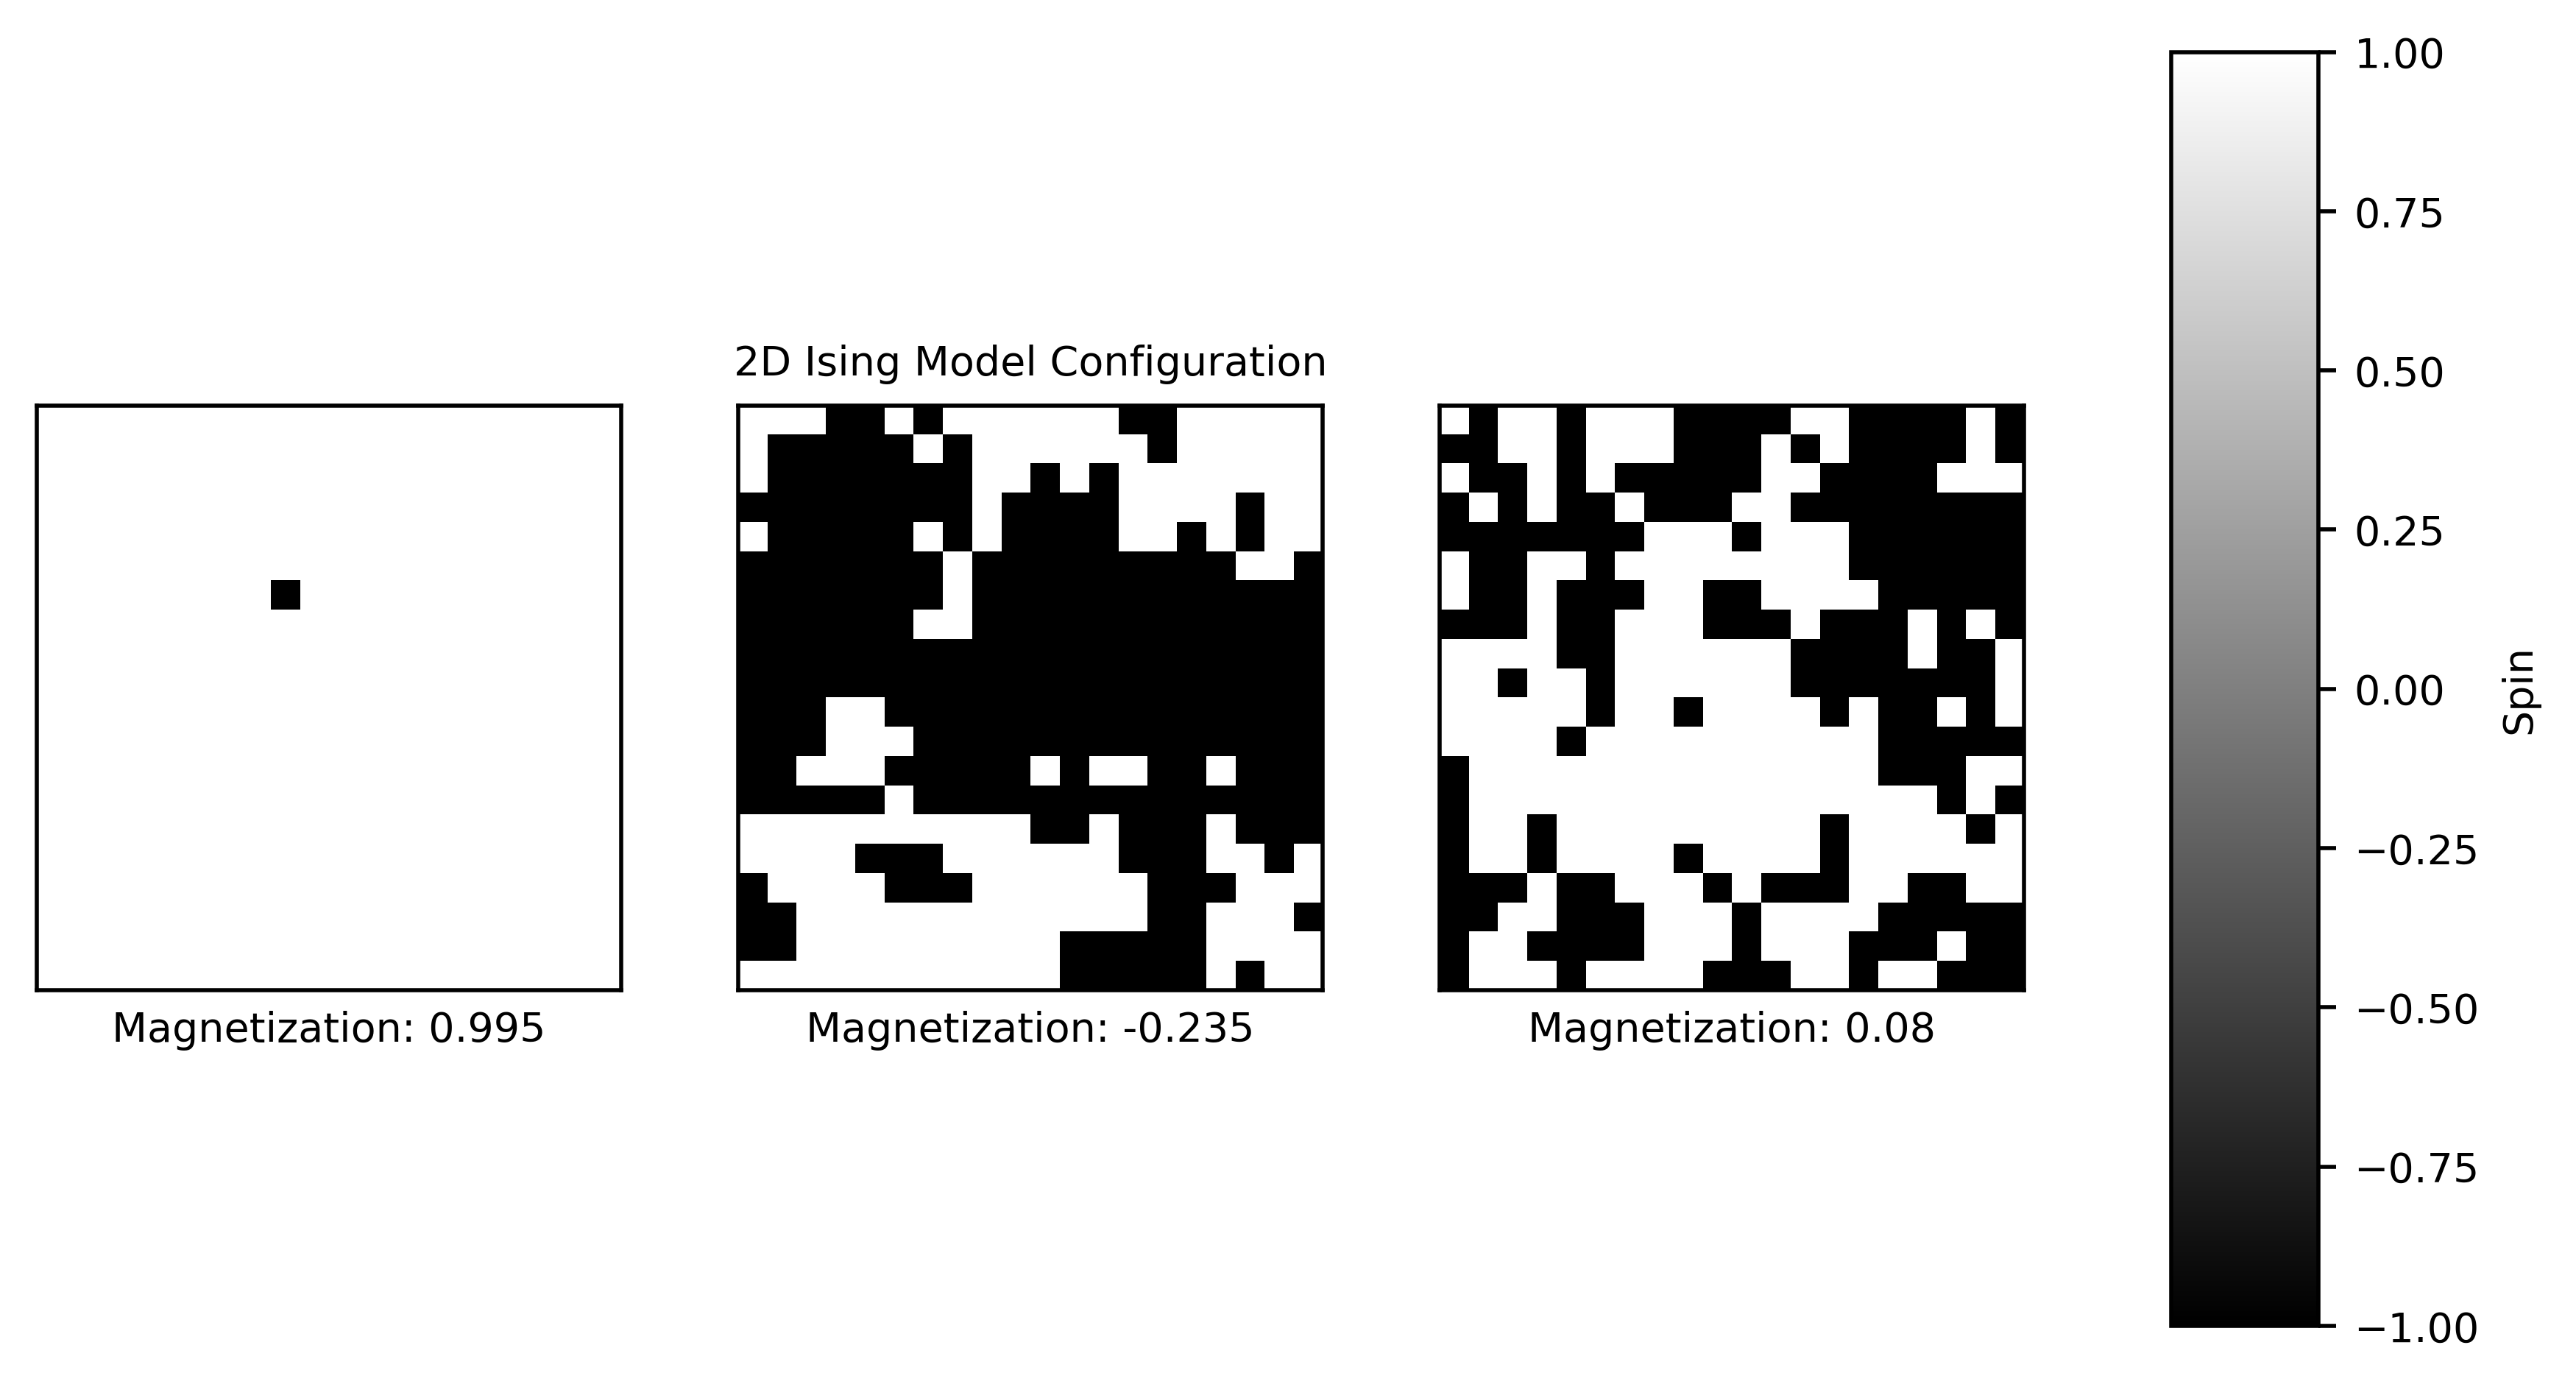

In [256]:
L = 20
temperatures = np.linspace(1.5, 3.5, 30) 
numSamplesPerT = 200
equilibrationSteps = 1000

configurations, magnetizations = generate_data(L, temperatures, numSamplesPerT, equilibrationSteps)
print(f"Generated {len(configurations)} data points.")
plot_lattice(configurations,magnetizations)

In [257]:
# Normalize and flatten spin configuration data
# - Convert spin configurations from {-1, 1} to {0, 1}
# - Flatten each configuration from a 2D array of size (L, L) to a 1D array of size (L*L)
x_data = (np.array(configurations).reshape(-1, L*L) + 1) / 2

# Create an array of temperatures corresponding to each configuration
# - Each temperature is repeated numSamplesPerT times
temp_data = np.array([np.repeat(T_, numSamplesPerT) for T_ in temperatures]).flatten()

# Split the data into training and testing sets
# - x_data: Spin configurations
# - temp_data: Corresponding temperatures
# - magnetizations: Corresponding magnetizations
x_train, x_test, temp_train, temp_test, magn_train, magn_test = train_test_split(
    x_data, temp_data, magnetizations, random_state=42, shuffle=True
)





### Variational Autoencoder (VAE)

A Variational Autoencoder (VAE) is a type of generative model that learns to represent high-dimensional data in a lower-dimensional latent space. VAEs are composed of two main components: an encoder and a decoder.

- **Encoder**: The encoder maps input data to a latent space by outputting the parameters (mean and variance) of a probability distribution.
- **Decoder**: The decoder samples from this latent distribution and maps these samples back to the original data space to reconstruct the input data.

The key idea behind VAEs is to learn a probabilistic model of the data. This involves not just mapping data to a lower-dimensional space, but also ensuring that the learned latent space follows a specific distribution (usually a standard normal distribution).

#### VAE Components

1. **Encoder**:
   - The encoder takes the input data $ x $ and maps it to the parameters of a latent distribution: the mean $ \mu $ and the variance $ \sigma^2 $.
   - This can be represented as:
     $
     (\mu, \sigma^2) = \text{Encoder}(x)
     $

2. **Decoder**:
   - The decoder takes samples $ z $ from the latent distribution and maps them back to the data space to reconstruct the input $ \hat{x} $.
   - This can be represented as:
     $
     \hat{x} = \text{Decoder}(z)
     $
   - where $ z $ is sampled from $ \mathcal{N}(\mu, \sigma^2) $.

3. **Loss Function**:
   - The VAE is trained using a loss function that combines two terms: the reconstruction loss and the KL divergence.
   - The **reconstruction loss** measures how well the decoder reconstructs the input data. It is typically the binary cross-entropy or mean squared error between the input $ x $ and the reconstruction $ \hat{x} $.
   - The **KL divergence** measures how close the learned latent distribution is to a prior distribution (usually a standard normal distribution $ \mathcal{N}(0, 1) $).
   - The total loss function $ \mathcal{L} $ can be written as:
     $
     \mathcal{L} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - \text{KL}(q(z|x) \| p(z))
     $
     - The first term $ \mathbb{E}_{q(z|x)}[\log p(x|z)] $ is the expected log-likelihood of the reconstruction, also known as the reconstruction loss.
     - The second term $ \text{KL}(q(z|x) \| p(z)) $ is the KL divergence, which regularizes the latent space to be close to the prior distribution.

#### Mathematical Formulation

- **Reconstruction Loss**:
  $
  \text{Reconstruction Loss} = -\mathbb{E}_{q(z|x)}[\log p(x|z)]
  $
  This term ensures that the decoder is able to accurately reconstruct the input data from the latent representation.

- **KL Divergence**:
  $
  \text{KL}(q(z|x) \| p(z)) = \frac{1}{2} \sum_{i=1}^d \left( 1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2 \right)
  $
  This term measures how much the distribution $ q(z|x) $ (the learned latent distribution) diverges from the prior distribution $ p(z) $, usually a standard normal distribution.

### Summary

VAEs provide a powerful framework for learning complex distributions by combining the strengths of both variational inference and deep learning. By training the encoder and decoder networks jointly, VAEs learn a compact and structured latent representation of the data, enabling efficient generation of new data samples and robust feature extraction.

In [271]:
def sampling(args):
    """
    Samples from the latent space using the reparameterization trick.
    
    This trick allows backpropagation through the stochastic sampling step by 
    introducing a random noise variable (epsilon) and parameterizing the latent 
    variables in terms of the mean and log variance.
    
    Parameters:
    - args: Tuple containing the mean (z_mean) and log variance (z_log_var) of the latent variables.

    Returns:
    - A sampled latent variable using the formula:
      z = z_mean + exp(0.5 * z_log_var) * epsilon
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_dim, latent_dim):
    """
    Builds the encoder model for the VAE.
    
    The encoder takes input data and produces the mean and log variance of the latent 
    variables, and samples from the latent distribution using the reparameterization trick.
    
    Parameters:
    - input_dim: Dimensionality of the input data.
    - latent_dim: Dimensionality of the latent space.

    Returns:
    - An encoder model that outputs the mean, log variance, and sampled latent variable.
    """
    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_dim):
    """
    Builds the decoder model for the VAE.
    
    The decoder takes the latent variables and reconstructs the input data.
    
    Parameters:
    - latent_dim: Dimensionality of the latent space.
    - output_dim: Dimensionality of the output data (should match input_dim).

    Returns:
    - A decoder model that outputs the reconstructed data.
    """
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(32, activation='relu')(latent_inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(output_dim, activation='sigmoid')(x)
    return Model(latent_inputs, outputs, name="decoder")

def build_vae(encoder, decoder, input_dim):
    """
    Combines the encoder and decoder into the VAE model.
    
    The VAE model is trained using a custom loss function that combines the reconstruction loss 
    and the KL divergence. This function also compiles the model.
    
    Parameters:
    - encoder: The encoder model.
    - decoder: The decoder model.

    Returns:
    - A VAE model with the combined loss function.
    """
    inputs = encoder.input
    z_mean, z_log_var, z = encoder(inputs)
    outputs = decoder(z)
    vae = Model(inputs, outputs, name="vae")

    # VAE loss
    reconstruction_loss = binary_crossentropy(inputs, outputs) * input_dim
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    return vae

def train_vae(vae, data, epochs=100, batch_size=64, learning_rate=1e-4):
    """
    Trains the VAE model using the provided data.
    
    Parameters:
    - vae: The VAE model to be trained.
    - data: Training data.
    - epochs: Number of epochs to train the model.
    - batch_size: Size of the batches for training.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - None. The model is trained in-place.
    """
    vae.compile(optimizer=Adam(learning_rate=learning_rate))
    # Use this if you're getting the M1/M2 mac warning (and comment the line above)
    #vae.compile(optimizer=LegacyAdam(learning_rate=learning_rate))

    vae.fit(data, epochs=epochs, batch_size=batch_size, verbose=0)


In [277]:
# Visualize latent space
def visualize_latent_space(encoder, data, temp, magn):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(10, 6))
    plt.scatter(z_mean, magn, c=temp, alpha=0.7, edgecolor='black')
    plt.title('Correlation of Latent Encoding and Magnetization of Spin Configurations')
    plt.xlabel('z_mean Value')
    plt.ylabel('Magnetization')
    plt.colorbar(label="Temperature")
    plt.show()

def visualize_phase(encoder, data, temp):
    z_mean, _, _ = encoder.predict(data)
    # Initialize lists for high and low categories
    high = []
    low = []

    # Create binary labels based on threshold
    t_label = [0 if t < 2.27 else 1 for t in temp]

    # Separate z_mean values into high and low based on t_label
    for cnt, e in enumerate(t_label):
        if e == 0:
            low.append(z_mean[:, 0][cnt])
        else:
            high.append(z_mean[:, 0][cnt])

    # Plot histograms with improved aesthetics
    plt.figure(figsize=(10, 6))

    plt.hist(low, bins=30, alpha=0.7, color='blue', label='Paramagnetic', edgecolor='black')
    plt.hist(high, bins=30, alpha=0.7, color='red', label='Feromagnetic', edgecolor='black')

    plt.title('Distribution of z_mean Values by Phase')
    plt.xlabel('z_mean Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Finally, our objective is to train a machine learning model using a dataset comprising spin configurations generated across a range of temperatures, 
with the aim of exploring the learned representation within its bottleneck layer.

To achieve this, we've implemented a one-dimensional bottleneck architecture. 

By constraining the model to encode as much information as possible into this single dimension, we hope to get a clearer interpretation of the model's learned features.

It's important to note that in this setup, we don't anticipate achieving perfect training loss. 

Given that we're compressing $30$ x $30$ spin configuration samples into a single numerical representation, some loss of generality is inevitable. 

Nonetheless, this compression forces the model to distill important information necessary for distinguishing between the two phases into a single dimension. 

This extracted feature could potentially serve as the order parameter we are searching for.

In [273]:
input_dim = L * L
latent_dim = 1

encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, input_dim)
vae = build_vae(encoder, decoder, input_dim)
train_vae(vae, x_train, epochs=300)

### Iterpretation 1:
The following plot illustrates the correlation between the latent encoding $z$, representing the one-dimensional bottleneck, and the magnetization of the encoded spin configurations. Additionally, we include information about the temperature at which the samples were generated.

We observe a clear linear relationship between these two variables, indicating a strong association between the one-dimensional representation and magnetization. This suggests that our machine learning model successfully approximated the order parameter of the phase transition.

We can also try to make sense of this correlation: Due to the strong bottleneck, the model is forced to identify a single quantity that encapsulates as much information as possible. 
The phase information is a plausible candidate for this, as it allows the model to effectively distinguish between samples.

47/47 [==============================] - 0s 396us/step


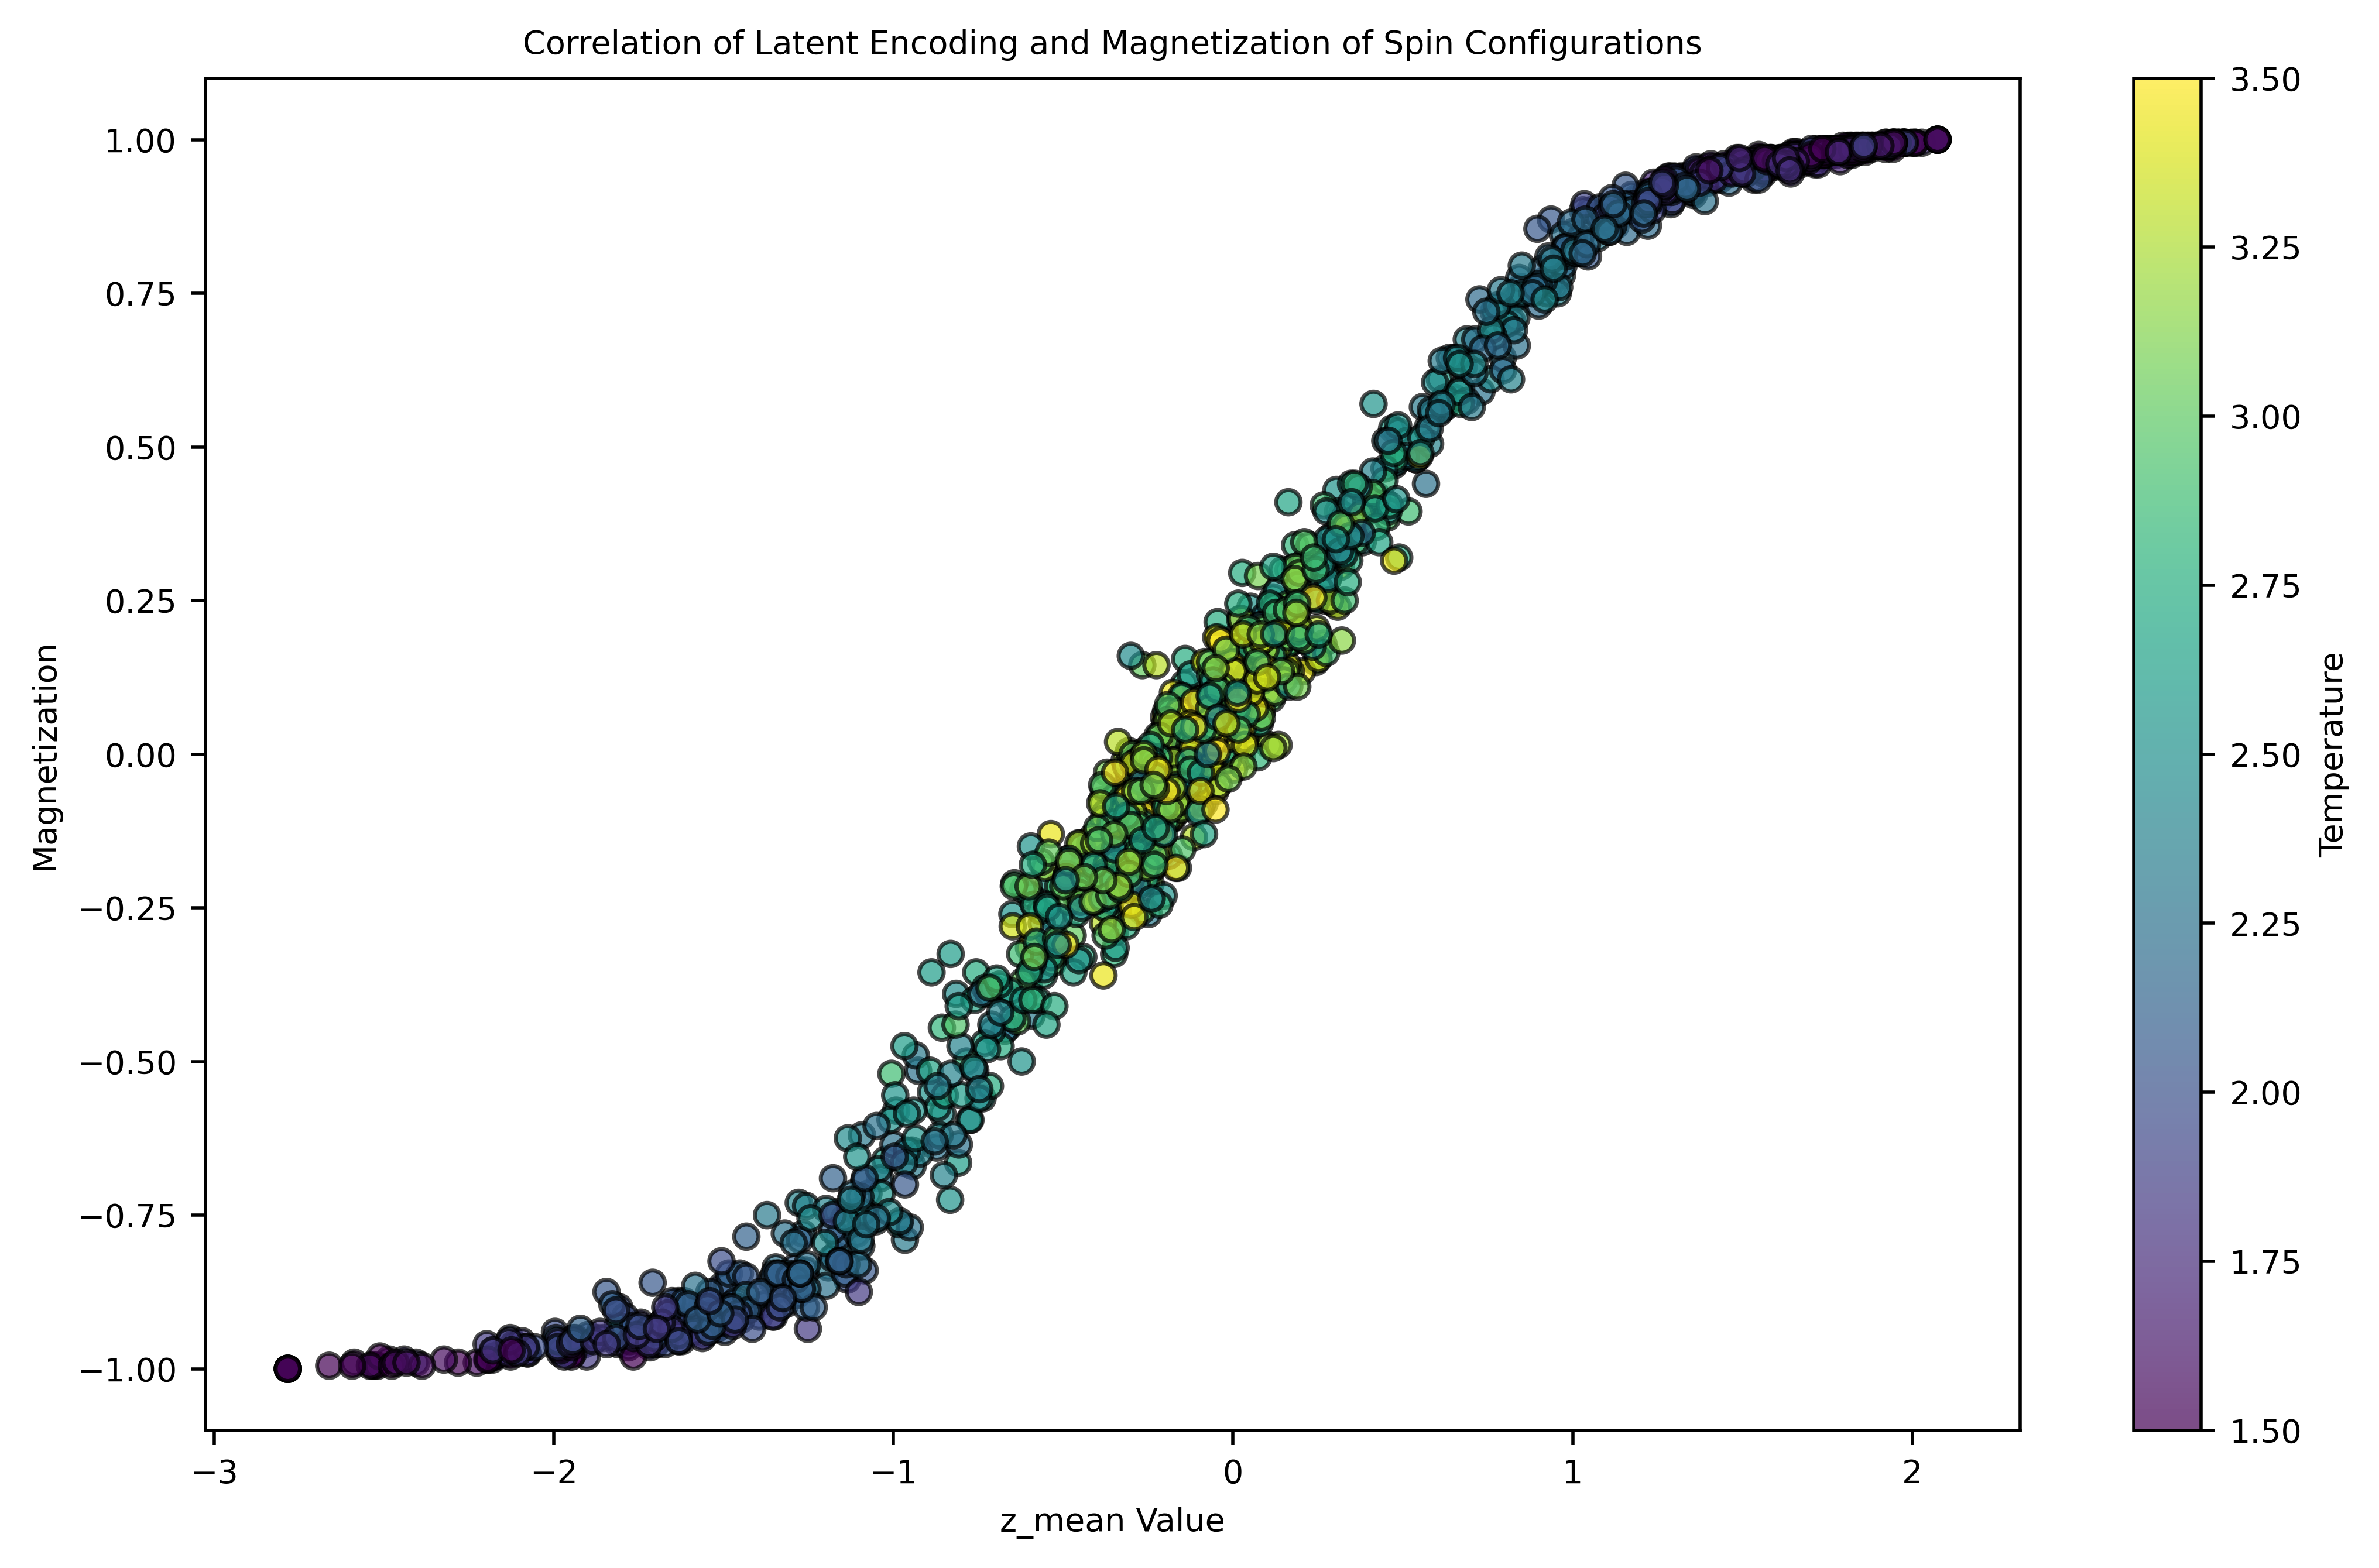

In [278]:
visualize_latent_space(encoder, x_test, temp_test, magn_test)

### Interpretation 2:
We can also visualize the distribution of the learned latent variables, categorized according to the two distinct phases. 

Notably, we observe that the model has delineated distinct regions within its latent representation corresponding to each phase.

47/47 [==============================] - 0s 463us/step


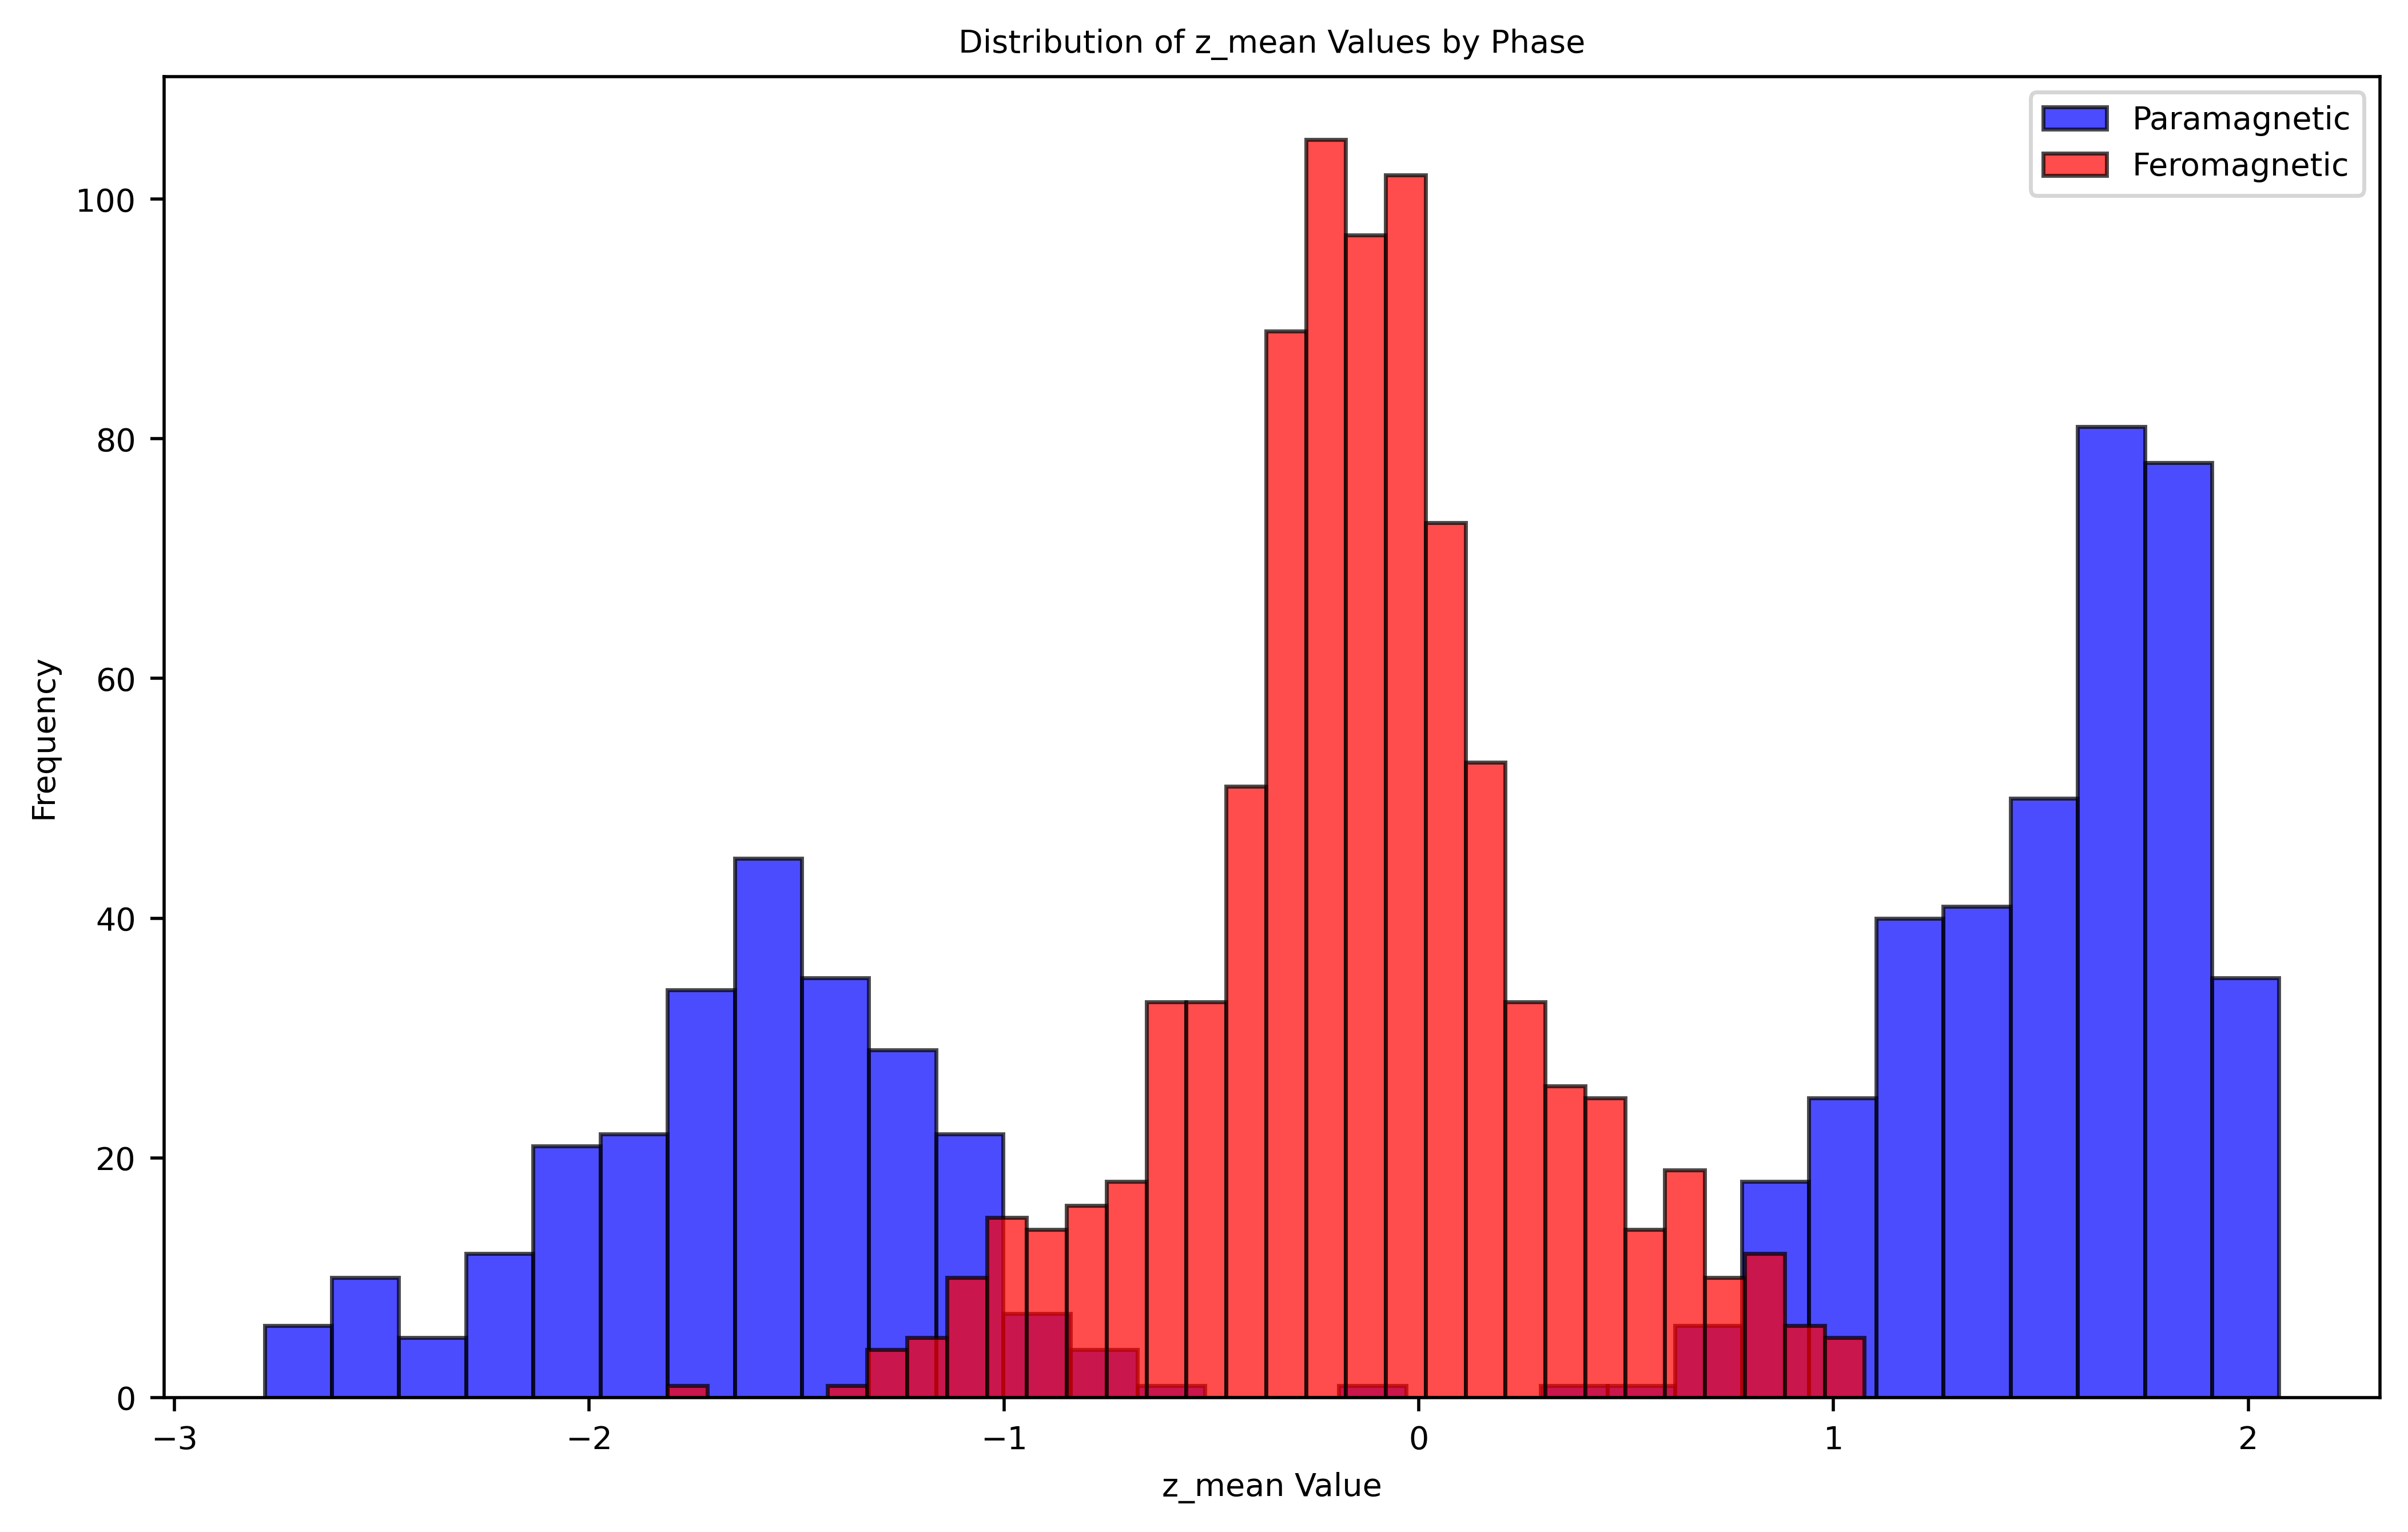

In [276]:
visualize_phase(encoder, x_test, temp_test)